In [5]:
#!pip install graphein MDAnalysis torch_geometric torchmetrics
#!apt-get install dssp

In [18]:
import os
import random
import glob
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pickle
import h5py
import collections

import networkx as nx
import numpy as np
import pandas as pd

from tqdm import tqdm
from functools import partial
from typing import Union, Literal, Any, Optional

# PyTorch Geometric importları
from torch.utils.data import DataLoader
from torch_geometric.data import Dataset, Batch, Data
from torch_geometric.nn import GATv2Conv, global_add_pool, global_mean_pool
from torchmetrics.functional.pairwise import pairwise_euclidean_distance
from torch_geometric.utils import to_undirected

# Graphein importları
import MDAnalysis as mda
from MDAnalysis.lib.distances import calc_dihedrals
from graphein.protein.config import ProteinGraphConfig, DSSPConfig
from graphein.protein.graphs import construct_graph
from graphein.protein.edges.distance import (
    add_aromatic_interactions,
    add_disulfide_interactions,
    add_hydrogen_bond_interactions,
    add_peptide_bonds,
    add_hydrophobic_interactions,
    add_ionic_interactions,
    add_k_nn_edges,
    add_distance_threshold
)
from graphein.protein.features.nodes.amino_acid import amino_acid_one_hot
from graphein.protein.features.nodes import asa, rsa
from graphein.protein.features.nodes.dssp import secondary_structure
from graphein.protein.visualisation import plot_protein_structure_graph
from graphein.protein.resi_atoms import RESI_THREE_TO_1

from enum import Enum

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

DATA_ROOT = "drive/MyDrive/protein_triplets_data"

print(f"Çalışma Ortamı: {DEVICE}")

Çalışma Ortamı: cuda


In [19]:
class ProjectConfig:
    def __init__(self):
        # ---------------------------------------------------------
        # 1. NODE FEATURE AYARLARI (True/False)
        # ---------------------------------------------------------
        self.use_coords = True          # Koordinatlar (x, y, z) -> Dim: 3
        self.use_b_factor = True        # B-Factor -> Dim: 1
        self.use_amino_acid = True      # One-Hot Amino Asit -> Dim: 20
        self.use_asa = True             # Accessible Surface Area -> Dim: 1
        self.use_rsa = True             # Relative Surface Area -> Dim: 1
        self.use_ss = True              # Secondary Structure (One-hot) -> Dim: 8
        self.use_backbone_dh = True     # Backbone Dihedrals (phi, psi, omega) -> Dim: 3
        self.use_sidechain_dh = True    # Sidechain Dihedrals (chi1...chi5) -> Dim: 5
        self.use_embedding = False      # ESM vb. Embedding -> Dim: esm_dim ayarına bak

        # Embedding Boyutu (Eğer use_embedding=True ise burası kullanılır)
        self.esm_dim = 1280 # Örn: ESM-2 8M için 320, 35M için 480, 150M için 640, 650M için 1280

        # ---------------------------------------------------------
        # 2. EDGE TYPE AYARLARI (True/False)
        # ---------------------------------------------------------
        self.edge_peptide = True        # Peptid Bağları
        self.edge_aromatic = True       # Aromatik Etkileşimler
        self.edge_disulfide = True      # Disülfit Bağları
        self.edge_hydrogen = True       # Hidrojen Bağları
        self.edge_hydrophobic = True    # Hidrofobik Etkileşimler
        self.edge_ionic = True          # İyonik Etkileşimler
        self.edge_knn = True            # K-Nearest Neighbors
        self.edge_distance = True       # Mesafe Eşiği (Distance Threshold)

        # Edge Parametreleri
        self.knn_k = 10                 # KNN için K değeri
        self.dist_threshold = 8.0       # Distance Threshold değeri

        # ---------------------------------------------------------
        # 3. MODEL HİPERPARAMETRELERİ
        # ---------------------------------------------------------
        self.hidden_dim = 64
        self.output_dim = 256
        self.dropout = 0.1
        self.lr = 0.0005
        self.batch_size = 8
        self.epochs = 50
        self.margin = 0.5

    @property
    def input_dim(self):
        """Seçilen özelliklere göre giriş boyutunu otomatik hesaplar."""
        dim = 0
        if self.use_coords: dim += 3
        if self.use_b_factor: dim += 1
        if self.use_amino_acid: dim += 20
        if self.use_asa: dim += 1
        if self.use_rsa: dim += 1
        if self.use_ss: dim += 8
        if self.use_backbone_dh: dim += 3
        if self.use_sidechain_dh: dim += 5
        if self.use_embedding: dim += self.esm_dim
        return dim

    def get_active_edge_funcs(self):
        """Seçilen edge tiplerine göre fonksiyon listesi döndürür."""
        edge_funcs = []
        if self.edge_peptide: edge_funcs.append(ProteinEdgeTypeFuncs.PEPTIDE_BONDS)
        if self.edge_aromatic: edge_funcs.append(ProteinEdgeTypeFuncs.AROMATIC_INTERACTIONS)
        if self.edge_disulfide: edge_funcs.append(ProteinEdgeTypeFuncs.DISULFIDE_INTERACTIONS)
        if self.edge_hydrogen: edge_funcs.append(ProteinEdgeTypeFuncs.HYDROGEN_BOND_INTERACTIONS)
        if self.edge_hydrophobic: edge_funcs.append(ProteinEdgeTypeFuncs.HYDROPHOBIC_INTERACTIONS)
        if self.edge_ionic: edge_funcs.append(ProteinEdgeTypeFuncs.IONIC_INTERACTIONS)

        if self.edge_knn:
            edge_funcs.append(partial(add_k_nn_edges, k=self.knn_k))
        if self.edge_distance:
            edge_funcs.append(partial(add_distance_threshold, long_interaction_threshold=self.dist_threshold))

        return edge_funcs

    def get_node_attributes_list(self):
        """Dataset sınıfının kullanacağı string listesini oluşturur."""
        attrs = []
        if self.use_coords: attrs.append("coords")
        if self.use_b_factor: attrs.append("b_factor")
        if self.use_amino_acid: attrs.append("amino_acid_one_hot")
        if self.use_asa: attrs.append("asa")
        if self.use_rsa: attrs.append("rsa")
        if self.use_ss: attrs.append("ss")
        if self.use_backbone_dh: attrs.append("backbone_dihedral_radians")
        if self.use_sidechain_dh: attrs.append("sidechain_dihedral_radians")
        if self.use_embedding: attrs.append("embedding")
        return attrs

In [20]:
class ProteinEdgeTypeFuncs(Enum):
    AROMATIC_INTERACTIONS = add_aromatic_interactions
    DISULFIDE_INTERACTIONS = add_disulfide_interactions
    HYDROGEN_BOND_INTERACTIONS = add_hydrogen_bond_interactions
    PEPTIDE_BONDS = add_peptide_bonds
    HYDROPHOBIC_INTERACTIONS = add_hydrophobic_interactions
    IONIC_INTERACTIONS = add_ionic_interactions
    K_NN_EDGES = add_k_nn_edges
    DISTANCE_THRESHOLD = add_distance_threshold

    @classmethod
    def get_members(cls):
        return [
            cls.AROMATIC_INTERACTIONS,
            cls.DISULFIDE_INTERACTIONS,
            cls.HYDROGEN_BOND_INTERACTIONS,
            cls.PEPTIDE_BONDS,
            cls.HYDROPHOBIC_INTERACTIONS,
            cls.IONIC_INTERACTIONS,
            cls.K_NN_EDGES,
            cls.DISTANCE_THRESHOLD
        ]

In [21]:
class ProteinNodeMetaDataFuncs(Enum):
    AMINO_ACID_ONE_HOT = amino_acid_one_hot

    @classmethod
    def get_members(cls):
        return [
            cls.AMINO_ACID_ONE_HOT,
        ]


In [22]:
class ProteinGraphMetaDataFuncs(Enum):
    ASA = asa
    RSA = rsa
    SECONDARY_STRUCTURE = secondary_structure

    @classmethod
    def get_members(cls):
        return [
            cls.ASA,
            cls.RSA,
            cls.SECONDARY_STRUCTURE
        ]

In [23]:
class TripletProteinGraphDataset(Dataset):
    def __init__(self,
                 mapper,
                 root,
                 config: ProjectConfig, # Artık config alıyoruz
                 esm2_embedding_path: str = None
                 ):
        self.triplets = mapper.triplets
        self.mapper = mapper
        self.config = config # Config'i kaydet

        self.esm2_embedding_path = esm2_embedding_path
        processed_dir = os.path.join(root, "processed")

        if not os.path.exists(processed_dir):
            os.makedirs(processed_dir)

        # Load Embedding
        self.esm2_embeddings = {}
        if self.config.use_embedding and self.esm2_embedding_path and os.path.exists(self.esm2_embedding_path):
            self.load_embeddings(self.esm2_embedding_path, "esm2")

        # Config'den Edge Tiplerini Al
        self.edge_types = self.config.get_active_edge_funcs()

        # MetaData Fonksiyonları (Graphein için)
        self.node_metadata_funcs = ProteinNodeMetaDataFuncs.get_members()
        self.graph_metada_funcs = ProteinGraphMetaDataFuncs.get_members()

        # Config'den Node Özellik Listesini Al
        self.node_attributes = self.config.get_node_attributes_list()

        # Edge Attributes (Sabit kalabilir veya config'e eklenebilir)
        self.edge_attributes = ['kind', 'edge_attr', 'euclidean_distance']

        super().__init__(root)


    @property
    def processed_file_names(self):
        """
        Returns the list of files that should exist in the processed directory.
        PyG uses this to decide whether to run process().
        """
        unique_paths = set()
        for t in self.triplets:
            unique_paths.add(t['anchor'])
            unique_paths.update(t['positives'])
            unique_paths.update(t['negatives'])

        # Convert full paths to expected .pt filenames
        file_names = [os.path.basename(p).replace(".pdb", ".pt") for p in unique_paths]
        return file_names

    def download(self):
        # Not needed for local files, but required by abstract class
        pass

    @property
    def raw_file_names(self):
        """
        Required by PyG. Since we use a mapper for local files
        and don't expect files in a specific 'raw' folder, return empty.
        """
        return []

    def len(self) -> int:
        return len(self.triplets * 10)


    def load_embeddings(self, path, name):
        with h5py.File(path, "r") as h5_file:
            for grp in h5_file.keys():
                self.esm2_embeddings[grp] = {}
                for seq in h5_file[grp].keys():
                    self.esm2_embeddings[grp][seq] = np.array(h5_file[grp][seq])

    def process(self):
        """
        Iterates over ALL unique PDBs in the triplets (anchors, positives, negatives).
        Constructs graphs, saves .pickle and .pt files.
        """
        print("Gathering unique PDB files...")
        unique_paths = set()
        for t in self.triplets:
            unique_paths.add(t['anchor'])
            unique_paths.update(t['positives'])
            unique_paths.update(t['negatives'])

        print(f"Found {len(unique_paths)} unique proteins to process.")

        for path in tqdm(list(unique_paths), desc="Processing Proteins"):
            pdb_code = os.path.splitext(os.path.basename(path))[0]

            pt_path = os.path.join(self.processed_dir, f"{pdb_code}.pt")
            pickle_path = os.path.join(self.processed_dir, f"{pdb_code}.pickle")

            # Skip if exists
            if os.path.exists(pt_path) and os.path.exists(pickle_path):
                continue

            # 1. Build Graph
            try:
                g = self._build_graph(path)
                if g is None: continue
            except Exception as e:
                print(f"Error building graph for {pdb_code}: {e}")
                continue

            # 2. Convert to Data
            data = self.create_pytorch_geometric_data_object(g)

            # 3. Save to Disk
            # Save pickle
            with open(pickle_path, "wb") as f:
                pickle.dump(g, f)

            # Save PT
            torch.save(data, pt_path)

    def _build_graph(self, path: str) -> Data:
        config = ProteinGraphConfig(
            edge_construction_functions=self.edge_types,
            node_metadata_functions=self.node_metadata_funcs,
            graph_metadata_functions=self.graph_metada_funcs,
            dssp_config=DSSPConfig(executable="dssp"),
            verbose=False
        )

        # 2. Construct Raw Graph (Graphein)
        # Note: Chain selection might need adjustment depending PDBs. Defaulting to first found or 'A'.
        try:
            g = construct_graph(config=config, path=path, verbose=False)
        except Exception as e:
            print(f"Failed to construct graph for {path}: {e}")
            return None

        # 3. Process Graph (Feature Engineering from GraphBepi)
        # We need to extract chain_id from the graph or filename.
        # Graphein usually stores chain info in node IDs (Example: "A:ALA:123")
        first_node = list(g.nodes())[0]
        chain_id = first_node.split(":")[0]
        pdb_code = os.path.basename(path).replace(".pdb", "")

        g = self.process_networkx_graph(g, chain_id, path, pdb_code)

        return g

    def process_networkx_graph(self, g, chain_id, pdb_path, pdb_code, unique_ss=None, unique_edge_types=None):
        if unique_ss is None: unique_ss = ['-', 'B', 'G', 'E', 'T', 'S', 'I', 'H']
        if unique_edge_types is None: unique_edge_types = ['peptide_bond', 'knn', 'hydrophobic', 'aromatic', 'hbond', 'ionic', 'disulfide']

        sequence = g.graph.get(f"sequence_{chain_id}")

        for index, (n, d) in enumerate(g.nodes(data=True)):
            aa = n.split(":")[1]

            d['chain_id'] = chain_id
            d['residue_name'] = aa
            d['residue_number'] = int(n.split(":")[2])

            # Clean ASA/RSA/SS
            for key in ["asa", "rsa", "ss"]:
                if isinstance(d.get(key), pd.core.series.Series):
                    val = d.get(key).dropna()
                    val = list(val[val != 0].to_dict().values()) if key != "ss" else list(val.unique())
                    d[key] = val[0] if val else (0.0 if key != "ss" else "-")

            # Defaults
            if not d.get("asa"): d["asa"] = 0
            if not d.get("rsa"): d["rsa"] = 0.0
            if not d.get("ss"): d["ss"] = "-"

            # One hot SS
            d["ss"] = self.one_hot_encode([d["ss"]], unique_ss)[0].tolist()

            # Dihedrals
            d["backbone_dihedral_radians"] = self.calculate_backbone_dihedrals(pdb_path, d)
            d["sidechain_dihedral_radians"] = self.calculate_sidechain_dihedrals(pdb_path, d)

            # Embeddings
            if self.esm2_embeddings and sequence:
                # Assuming key is "PDB_CHAIN" or just "PDB"
                key = f"{pdb_code}_{chain_id}"
                if key not in self.esm2_embeddings: key = pdb_code # Try just PDB code

                if key in self.esm2_embeddings:
                    emb = self.esm2_embeddings[key][sequence][index]
                    d["embedding"] = emb

        # Edge Features
        for s, t, d in g.edges(data=True):
            edge_type = list(d["kind"])
            if "knn" in edge_type and len(edge_type) > 1: edge_type.remove("knn")

            d["edge_attr"] = [self.one_hot_encode([_type], unique_edge_types)[0].tolist() for _type in edge_type]
            d["kind"] = edge_type

            # Euclidean Distance
            source_coords = g.nodes[s]["coords"]
            target_coords = g.nodes[t]["coords"]
            d["euclidean_distance"] = round(np.sqrt(np.sum(np.square(source_coords - target_coords))).item(), 5)

        # Scale Graph (B-factor, ASA, RSA)
        g = self.scale_graph(g)
        return g

    def create_pytorch_geometric_data_object(self, g, to_undirected_graph=True):
        node_indexes_mapping = {}
        node_features = collections.defaultdict(list)

        for index, (n, d) in enumerate(g.nodes(data=True)):
            _list = []
            for k in self.node_attributes:
                v = d.get(k)
                if v is None:
                    continue

                if isinstance(v, (list, np.ndarray)):
                    _list.extend(list(v))
                else:
                    _list.append(v)

            node_features["x"].append(_list)
            node_features["pos"].append(d["coords"].tolist())
            node_indexes_mapping[n] = index

        edge_features = collections.defaultdict(list)
        for s, t, d in g.edges(data=True):
            for index, _ in enumerate(d["kind"]):
                edge_attr = []
                edge_features["edge_index"].append([node_indexes_mapping[s], node_indexes_mapping[t]])
                edge_attr.extend(d["edge_attr"][index])
                edge_attr.append(d["euclidean_distance"])
                edge_features["edge_attr"].append(edge_attr)

        data = Data()
        data.x = torch.tensor(node_features["x"], dtype=torch.float)
        data.pos = torch.tensor(node_features["pos"], dtype=torch.float)

        if edge_features["edge_index"]:
            data.edge_index = torch.tensor(edge_features["edge_index"], dtype=torch.long).t().contiguous()
            data.edge_attr = torch.tensor(edge_features["edge_attr"], dtype=torch.float)
        else:
            # Handle graphs with no edges
            data.edge_index = torch.empty((2, 0), dtype=torch.long)
            data.edge_attr = torch.empty((0, 0), dtype=torch.float)

        if to_undirected_graph and data.edge_index.numel() > 0:
            data.edge_index, data.edge_attr = to_undirected(data.edge_index, data.edge_attr)

        return data

    def one_hot_encode(self, classes, class_labels):
        encoding = np.zeros((len(classes), len(class_labels)))
        for i, class_ in enumerate(classes):
            if class_ in class_labels:
                encoding[i, class_labels.index(class_)] = 1
        return encoding

    def min_max_scaler(self, values, index_to_aa):
        min_val, max_val = min(values), max(values)
        scaled_values = [round((val - min_val) / (max_val - min_val), 5) if max_val - min_val != 0 else 0 for val in values]
        return {index_to_aa[index]: value for index, value in enumerate(scaled_values)}

    def scale_graph(self, g, scale_attributes=None):
        if scale_attributes is None: scale_attributes = ["b_factor", "asa", "rsa"]
        index_to_aa = {index: n for index, n in enumerate(g.nodes(data=False))}
        for attr in scale_attributes:
            vals = [d.get(attr, 0) for _, d in g.nodes(data=True)]
            scaled_dict = self.min_max_scaler(vals, index_to_aa)
            for n, d in g.nodes(data=True):
                d[attr] = scaled_dict[n]
        return g

    def calculate_backbone_dihedrals(self,
                                     pdb_path: str,
                                     aa_props: dict,
                                     to_degree: bool = False,
                                     normalize: bool = True) -> list:

        # Load PDB file
        u = mda.Universe(pdb_path)

        # Calculate backbone dihedrals (phi, psi, omega)
        for res in u.residues:
            # Match residue number, name, and chain ID (segid)
            if res.resid == aa_props["residue_number"] and res.resname == aa_props["residue_name"] and res.segid == aa_props["chain_id"]:

                backbone_dihedrals_dict = {
                    "phi": res.phi_selection(),
                    "psi": res.psi_selection(),
                    "omega": res.omega_selection()
                }

                if all([True if not v else False for v in backbone_dihedrals_dict.values()]):
                    print(f"Warning: No backbone dihedrals found for {res.resname} {res.resindex} in {pdb_path}")

                backbone_dihedral_radians = []
                for dihedral_selection in backbone_dihedrals_dict.values():
                    if dihedral_selection:
                        coords = [a.position for a in dihedral_selection.atoms]
                        radian = calc_dihedrals(coords[0], coords[1], coords[2], coords[3])

                        if to_degree:
                            value = round(np.degrees(radian).item(), 5)
                        else:
                            value = round(radian.item(), 5)

                        if to_degree and normalize:
                            value = (value - (-180.0)) / (180.0 - (-180.0))
                        elif normalize:
                            value = (value - (-np.pi)) / (np.pi - (-np.pi))

                        backbone_dihedral_radians.append(round(value, 5))
                    else:
                        backbone_dihedral_radians.append(0.0)

                return backbone_dihedral_radians

        # Fallback if residue not found
        return [0.0, 0.0, 0.0]

    def calculate_sidechain_dihedrals(self,
                                      pdb_path: str,
                                      aa_props: dict,
                                      to_degree: bool = False,
                                      normalize: bool = True) -> list:

        # Define chi atoms dictionary
        # chi_atoms_dict is from: https://gist.github.com/lennax/0f5f65ddbfa278713f58
        chi_atoms_dict = dict(
            chi1=dict(
                ARG=['N', 'CA', 'CB', 'CG'], ASN=['N', 'CA', 'CB', 'CG'], ASP=['N', 'CA', 'CB', 'CG'],
                CYS=['N', 'CA', 'CB', 'SG'], GLN=['N', 'CA', 'CB', 'CG'], GLU=['N', 'CA', 'CB', 'CG'],
                HIS=['N', 'CA', 'CB', 'CG'], ILE=['N', 'CA', 'CB', 'CG1'], LEU=['N', 'CA', 'CB', 'CG'],
                LYS=['N', 'CA', 'CB', 'CG'], MET=['N', 'CA', 'CB', 'CG'], PHE=['N', 'CA', 'CB', 'CG'],
                PRO=['N', 'CA', 'CB', 'CG'], SER=['N', 'CA', 'CB', 'OG'], THR=['N', 'CA', 'CB', 'OG1'],
                TRP=['N', 'CA', 'CB', 'CG'], TYR=['N', 'CA', 'CB', 'CG'], VAL=['N', 'CA', 'CB', 'CG1'],
            ),
            chi2=dict(
                ARG=['CA', 'CB', 'CG', 'CD'], ASN=['CA', 'CB', 'CG', 'OD1'], ASP=['CA', 'CB', 'CG', 'OD1'],
                GLN=['CA', 'CB', 'CG', 'CD'], GLU=['CA', 'CB', 'CG', 'CD'], HIS=['CA', 'CB', 'CG', 'ND1'],
                ILE=['CA', 'CB', 'CG1', 'CD1'], LEU=['CA', 'CB', 'CG', 'CD1'], LYS=['CA', 'CB', 'CG', 'CD'],
                MET=['CA', 'CB', 'CG', 'SD'], PHE=['CA', 'CB', 'CG', 'CD1'], PRO=['CA', 'CB', 'CG', 'CD'],
                TRP=['CA', 'CB', 'CG', 'CD1'], TYR=['CA', 'CB', 'CG', 'CD1'],
            ),
            chi3=dict(
                ARG=['CB', 'CG', 'CD', 'NE'], GLN=['CB', 'CG', 'CD', 'OE1'], GLU=['CB', 'CG', 'CD', 'OE1'],
                LYS=['CB', 'CG', 'CD', 'CE'], MET=['CB', 'CG', 'SD', 'CE'],
            ),
            chi4=dict(
                ARG=['CG', 'CD', 'NE', 'CZ'], LYS=['CG', 'CD', 'CE', 'NZ'],
            ),
            chi5=dict(
                ARG=['CD', 'NE', 'CZ', 'NH1'],
            ),
        )

        # Load PDB file
        u = mda.Universe(pdb_path)

        # Calculate sidechain dihedrals (chi1, chi2, chi3, chi4, chi5)
        for res in u.residues:
            if res.resid == aa_props["residue_number"] and res.resname == aa_props["residue_name"] and res.segid == aa_props["chain_id"]:
                chi_radians = []
                for chi_res in chi_atoms_dict.values():
                    # Check if residue has this chi angle and if atoms exist in the structure
                    if chi_res.get(res.resname) and set(chi_res[res.resname]).issubset(set(a.name for a in res.atoms)):
                        chi_selected_atoms = dict.fromkeys(chi_res[res.resname], 1)
                        for a in res.atoms:
                            if chi_selected_atoms.get(a.name) is not None and not isinstance(chi_selected_atoms.get(a.name), np.ndarray):
                                chi_selected_atoms[a.name] = a.position

                        coords = list(chi_selected_atoms.values())

                        radian = calc_dihedrals(coords[0], coords[1], coords[2], coords[3])
                        if to_degree:
                            value = round(np.degrees(radian).item(), 5)
                        else:
                            value = round(radian.item(), 5)

                        if to_degree and normalize:
                            value = (value - (-180.0)) / (180.0 - (-180.0))
                        elif normalize:
                            value = (value - (-np.pi)) / (np.pi - (-np.pi))

                        chi_radians.append(round(value, 5))
                    else:
                        chi_radians.append(0.0)

                while len(chi_radians) < 5:
                    chi_radians.append(0.0)

                return chi_radians

        # Fallback
        return [0.0] * 5

    def _load_processed_graph(self, path):
        pdb_code = os.path.splitext(os.path.basename(path))[0]
        pt_path = os.path.join(self.processed_dir, f"{pdb_code}.pt")

        if os.path.exists(pt_path):
            return torch.load(pt_path,weights_only=False)
        else:
            # Fallback if not processed (though process() should have been called)
            print(f"Warning: {pdb_code} not found in processed files. Processing on the fly.")
            g = self._build_graph(path)
            return self.create_pytorch_geometric_data_object(g) if g else None

    def get(self, idx):
        real_idx = idx % len(self.triplets)
        t = self.triplets[real_idx]

        # Load graphs
        data_a = self._load_processed_graph(t["anchor"])
        data_p = self._load_processed_graph(random.choice(t["positives"]))
        data_n = self._load_processed_graph(random.choice(t["negatives"]))

        return data_a, data_p, data_n

In [24]:
class TripletDataPathMapper:
    """
    Protein klasör yapısını okuyup anchor–positive–negative üçlülerini çıkarır.
    originals/{id}.pdb
    positives/{id}/*.pdb
    negatives/{id}/*.pdb
    """
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.triplets = []
        self._map_data()

    def _map_data(self):
        originals = glob.glob(os.path.join(self.root_dir, 'originals', "*.pdb"))

        for anchor in originals:
            prot_id = os.path.splitext(os.path.basename(anchor))[0]

            pos_dir = os.path.join(self.root_dir, 'positives', prot_id)
            neg_dir = os.path.join(self.root_dir, 'negatives', prot_id)

            p_files = glob.glob(os.path.join(pos_dir, "*.pdb"))
            n_files = glob.glob(os.path.join(neg_dir, "*.pdb"))

            # Hem positive hem negative varsa triplet olarak ekleniyor
            if p_files and n_files:
                self.triplets.append({
                    'anchor': anchor,
                    'positives': p_files,
                    'negatives': n_files
                })

        print(f"Bulunan Protein Ailesi: {len(self.triplets)}")

In [25]:
def triplet_collate(data_list):
    """
    Dataset'ten dönen tripletleri batch'e dönüştürür.
    None dönenler (bozuk PDB) ayıklanır.
    """
    data_list = [x for x in data_list if x is not None]
    if not data_list:
        return None

    batch_a = Batch.from_data_list([x[0] for x in data_list])
    batch_p = Batch.from_data_list([x[1] for x in data_list])
    batch_n = Batch.from_data_list([x[2] for x in data_list])

    return batch_a, batch_p, batch_n

In [26]:
class DeepProteinGAT(nn.Module):
    """
    3 katmanlı GATv2 tabanlı protein embedding modeli.
    Pooling: global_mean
    Output normalize edilir (metric learning için).
    """
    def __init__(self, input_dim, hidden_dim, output_dim, heads=4):
        super().__init__()

        # GATv2 katmanları — Dropout kapalı (sinyal kaybetmemek için)
        self.conv1 = GATv2Conv(input_dim, hidden_dim, heads=heads, concat=True, dropout=0.0)
        self.conv2 = GATv2Conv(hidden_dim * heads, hidden_dim, heads=heads, concat=True, dropout=0.0)
        self.conv3 = GATv2Conv(hidden_dim * heads, output_dim, heads=1, concat=False, dropout=0.0)

        self.projection = nn.Linear(output_dim, output_dim)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        x = x.float()
        x = F.elu(self.conv1(x, edge_index))
        x = F.elu(self.conv2(x, edge_index))
        x = self.conv3(x, edge_index)

        x = global_mean_pool(x, batch)
        x = self.projection(x)
        x = F.normalize(x, p=2, dim=1)
        return x

In [27]:
def train_pipeline():
    # 1. Konfigürasyonu Oluştur
    cfg = ProjectConfig()

    # İsterseniz burada ayarları değiştirebilirsiniz:
    # cfg.use_embedding = True
    # cfg.edge_knn = False
    # cfg.knn_k = 5

    print(f"Hesaplanan Input Dimension: {cfg.input_dim}")

    mapper = TripletDataPathMapper(DATA_ROOT)
    if not mapper.triplets:
        print("Veri bulunamadı!")
        return

    # 2. Dataset'i Config ile Başlat
    dataset = TripletProteinGraphDataset(
        mapper,
        root=DATA_ROOT,
        config=cfg,  # Config nesnesini buraya veriyoruz
        esm2_embedding_path="path/to/embeddings.h5" # Eğer kullanacaksanız
    )

    loader = DataLoader(dataset, batch_size=cfg.batch_size, shuffle=True, collate_fn=triplet_collate)

    # 3. Modeli Config'deki boyutla başlat
    model = DeepProteinGAT(
        input_dim=cfg.input_dim,  # Otomatik hesaplanan boyut
        hidden_dim=cfg.hidden_dim,
        output_dim=cfg.output_dim
    ).to(DEVICE)

    optimizer = optim.Adam(model.parameters(), lr=cfg.lr)
    criterion = nn.TripletMarginLoss(margin=cfg.margin, p=2, swap=True, reduction='mean')

    print("Eğitim Başlıyor...")
    model.train()

    EPOCHS = cfg.epochs
    for epoch in range(EPOCHS):
        total_loss = 0
        valid_batches = 0

        for batch in loader:
            if batch is None:
                continue

            ba, bp, bn = batch
            ba, bp, bn = ba.to(DEVICE), bp.to(DEVICE), bn.to(DEVICE)

            optimizer.zero_grad()

            # Forward pass
            ea = model(ba)
            ep = model(bp)
            en = model(bn)

            # Triplet loss
            loss = criterion(ea, ep, en)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            valid_batches += 1

        avg_loss = total_loss / valid_batches if valid_batches > 0 else 0
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{EPOCHS} | Loss: {avg_loss:.4f}")

In [28]:
if __name__ == "__main__":
    train_pipeline()

Hesaplanan Input Dimension: 42
Bulunan Protein Ailesi: 1
Eğitim Başlıyor...
Epoch 10/50 | Loss: 0.4681
Epoch 20/50 | Loss: 0.1842
Epoch 30/50 | Loss: 0.4969
Epoch 40/50 | Loss: 0.4968
Epoch 50/50 | Loss: 0.4960


number of nodes: 776
number of edges: 4510
density: 0.0150


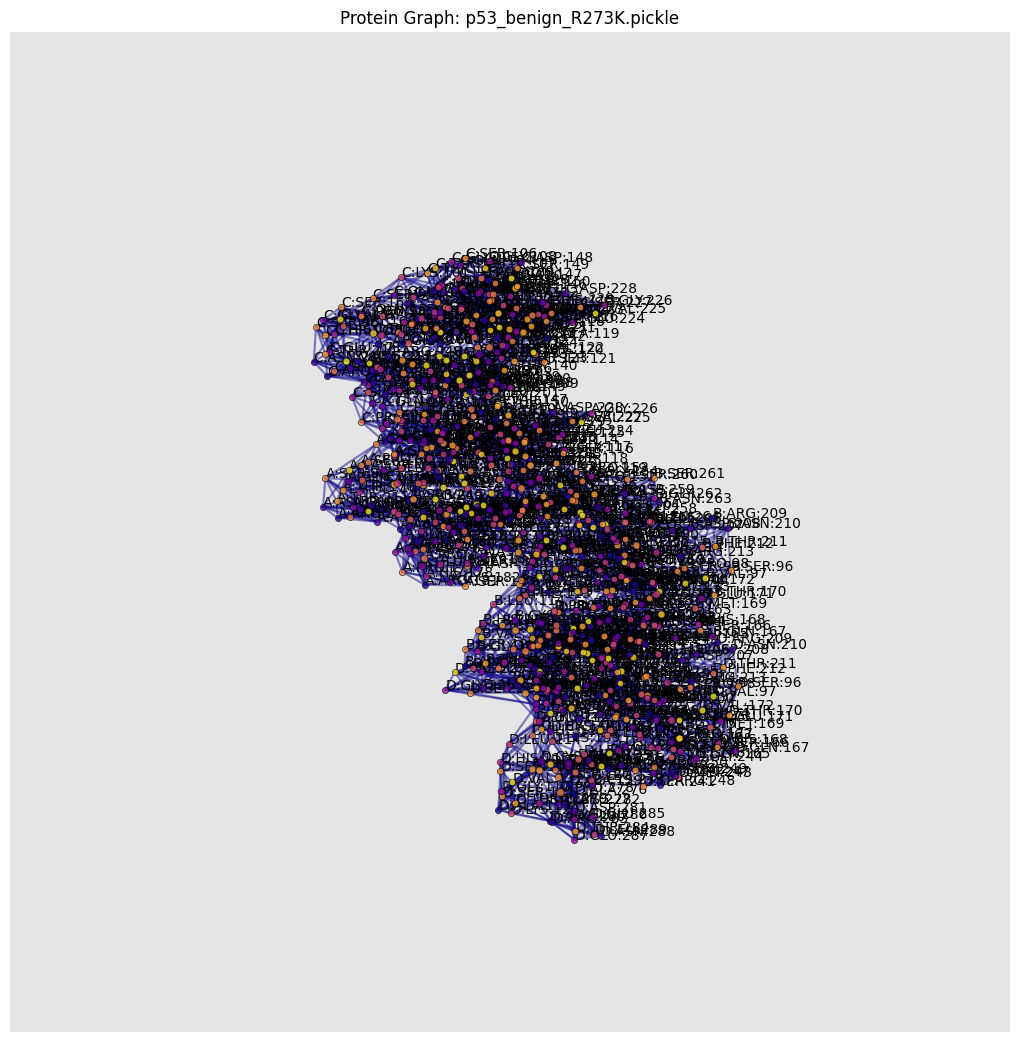

In [30]:
import os
import pickle
import matplotlib.pyplot as plt
from graphein.protein.visualisation import plot_protein_structure_graph

processed_dir = "drive/MyDrive/protein_triplets_data/processed"
pickle_files = [f for f in os.listdir(processed_dir) if f.endswith('.pickle')]
file_path = os.path.join(processed_dir, pickle_files[0])

with open(file_path, "rb") as f:
    g = pickle.load(f)

num_nodes = g.number_of_nodes()
num_edges = g.number_of_edges()
density = nx.density(g)

info_text = (
    f"Protein: {pickle_files[0]}\n"
    f"Nodes (Residues): {num_nodes}\n"
    f"Edges: {num_edges}"
    f"Density: {density:.4f}"
)
print(f"number of nodes: {num_nodes}")
print(f"number of edges: {num_edges}")
print(f"density: {density:.4f}")

ax = plot_protein_structure_graph(
    g,
    angle=30,
    plot_title=f"Protein Graph: {pickle_files[0]}",
    node_size_min=10,
    node_alpha=0.8,
    figsize=(12, 10),
    colour_nodes_by="residue_name",
    colour_edges_by="kind"
)

plt.show()